# Version information

In [5]:
import sys

sys.path.insert(0,'C:\\Users\\LAP17\\Documents\\Converter_WRSM\\pyleecan')

In [6]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date: ", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version: " + pyleecan.__version__)
import SciDataTool
print("SciDataTool version: " + SciDataTool.__version__)

Running date:  December 08, 2023
Pyleecan version: 1.5.2


SciDataTool version: 2.5.0


# Converter

## How to use a converter ?

This tutorial shows the way to call converter, and in a second part we explain this architecture. <br>
So, with this converter you can convert **motor IPMSM and SPMSM** for the moment with all slot, hole, notch, duct present in pyleecan. Just the **geometrical conversion** is present. <br>
This converter is between Motor-CAD and Pyleecan but the architecture is create to be reuse if you want an other converter.<br>
below is the code to call the converter :

from pyleecan.Classes.ConvertMC import ConvertMC
# select your file.mot
path = "path/to/mot.mot"

# select class of converter
conv = ConvertMC()

# select the direction of conversion

# to convert a file .mot in object machine  
machine = conv.convert_to_P(path)

# to convert a object machine in dict with setting use in Motor_cad 
other_dict = conv.convert_to_other(machine)

This converter could propose a reversibility, but attention the reversibility is not perfect. In fact, we don't know the fonctionnement of Motor-CAD, that is why, we return a dictionnary with all equivalent parameter between Motor-CAD and Pyleecan present in a file.mot 

If you want to find equivalent, approximation or error you have a file Pyleecan.log. In this file you have big step to example equivalent between parallel_slot and slotW21. Or if you have an error or approximation in conversion. <br>

In [8]:
# cleaning log file
f = open("/Users\LAP17\AppData\Roaming\pyleecan/Pyleecan.log", "w")
f.close()


## Converter architecture

### Class presentation

#### Class Converter

In this abstract class, we have variable use to convert, and different general methods. In fact, if you want to create an other converter you can reuse this methods.

#### ConverterMC

Contrary to convert, this class has all methods specific at Motor-CAD. We have all rules, and methods convert, and particularity. And ConvertMC inherits from Convert.

#### Rule

In this abstract class, you can find methods to select or set value in dict or in obj machine.

#### RuleComplex

RuleComplex inherits from Rule, this class works with functions who handles special cases 

#### RuleSimple

RuleSimple inherits from Rule, this class is use to equivalent parameter with just a multiplicator between param motor-cad and Pyleecan. 

#### RuleEquation

RuleEquation inherits from Rule, this class is use if equivalent between parameter motor-cad and Pyleecan is more difficult but can be solve with an equation. And if equation is complex, we can choose a RuleComplex.

### Architecture presentation

L'architecture du convertisseur va suivre l'interface Pyleecan. En effet, l'interface de pyleecan est composée de différente étape qui permet de définir la machine.

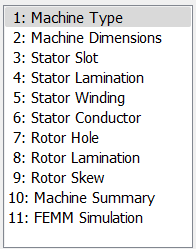

In [33]:
from IPython import display
display.Image("/Users/LAP17/Documents/Converter_WRSM/pyleecan/Tutorials/Images/Selection_machine.png")

Par exemple pour définir la Toyota_Prius, on définit : <br>
    - Machine type  <br>
    - Machine Dimensions<br>
    - Stator Slot<br>
    - ...<br>

Puis dansces étapes, nous définisons plus précisement, comme pour Machine Dimensions, on va définir la longueur du stator, du rotor... voir l'image ci-dessous :

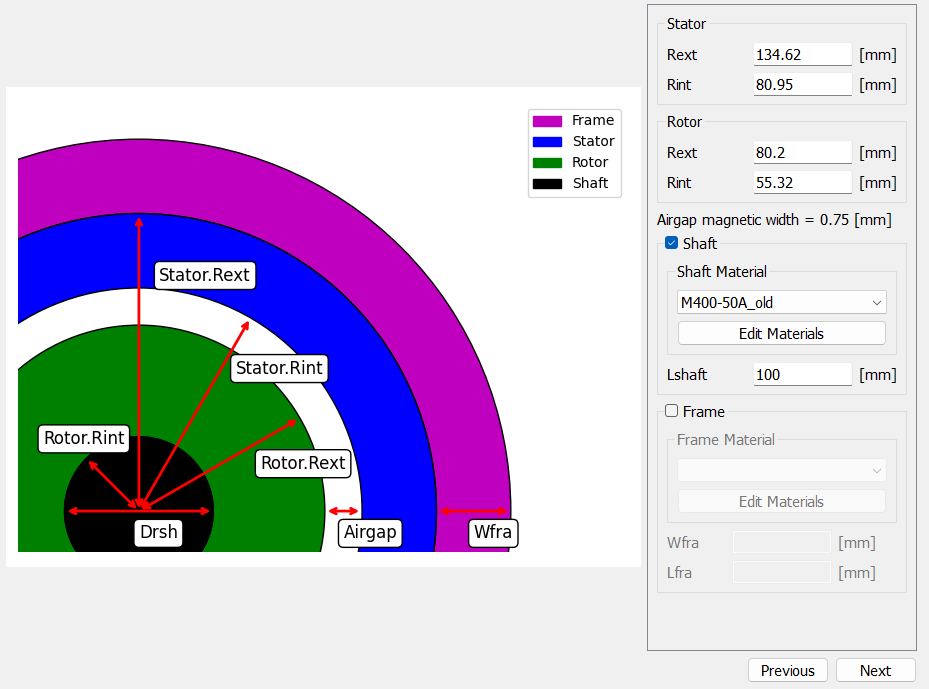

In [16]:
from IPython import display
display.Image("/Users/LAP17/Documents/Converter_WRSM/pyleecan/Tutorials/Images/Machine_dimension.png")

Le convertisseur va donc reproduire ces étapes de définitions pour définir la machine. 
L'objectif étant de pouvoir garder l'architecture si l'on souhaite refaire un convertisseur avec un autre logiciel.

C'est pourquoi le convertisseur est composé de 2 classes:
- la classe convert va contenir l'ensemble des méthodes qui peuvent être réutilisé pour n'importe quel conversion.
- la classe convertMC est spécifique à la conversion vers Pyleecan <-> motor-cad, elle devra être réécrite pour chaque convertisseur.


Fonctionnement du convertisseur :
On va commencer par sélectionner le type de machine.
Puis en fonction du type de machine nous allons appeler d'autre sélection, suivant un ordre précis (cf interface pyleecan). 
L'ensemble des méthode effectuant la sélection commence par "selection". Elles sont toutes dans convert.
L'objectif de ces méthodes est d'appeler les bonnes règles en fonction des besoins et d'orienter vers les autres fichiers selections.
Pour garder ces méthodes dans la classe convert, on va utiliser d'autres méthodes.

Ces méthodes commence par "convert" vont permettre de définir la machine en lui ajoutant ces grandes étapes (ces différentes classes), on a par exemple le type de machine, le type de slot, le type de notch...

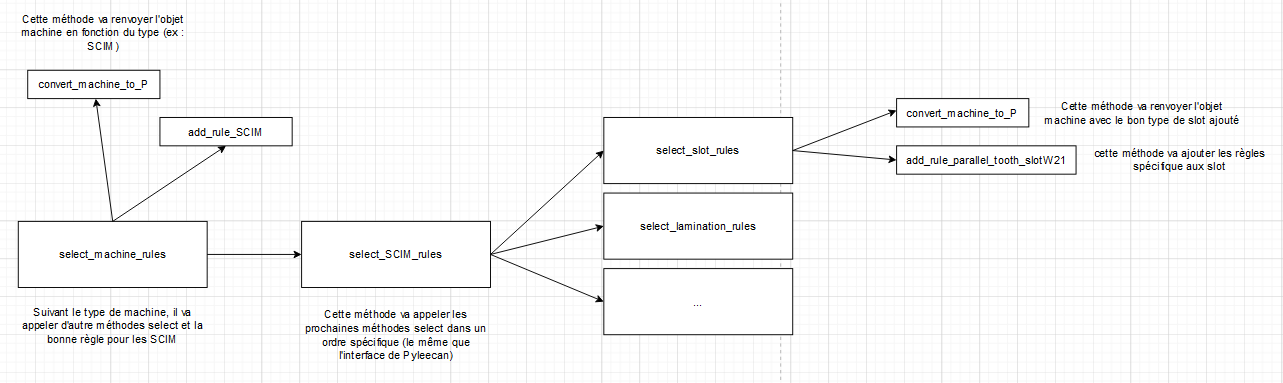

In [17]:
from IPython import display
display.Image("/Users/LAP17/Documents/Converter_WRSM/pyleecan/Tutorials/Images/schematics_architecture_converter.png")

Nous avons donc en fonction de la selection d'autre selection (d'autre step) comme ci-dessus:
L'objectif étant d'arriver au moment ou l'on puisse ajouter des règles. Pour cela, il faut soit être très précis comme savoir le type de slot, soit si la règle peut être généralisé par exemple les dimensions pour toutes les SCIM.


Nous arrivons donc aux règles, durant ce parcour les règles sont ajouté dans un ordre précis dans une liste rules_list.

A la fin de la sélection initier par la fonction selection_machine_rules nous nous retrouvons avec une liste de règle.
Nous allons donc convertir l'ensemble des règles et les ajouter dans l'objet machine. Cette conversion utilise le polymorphisme car en effet, il existe 3 types de règle :
- règle Simple qui permet de passer d'un paramètre à un autre avec seulement un multiplicateur (ex radius<->diameter)
- règle Equation qui permet de passer d'un paramètre à un autre mais en impliquant d'autre paramètre ou des conversion complex
(ex: y = a+2b -3x) 
- règle Complexe qui traite les autres situations, ces situations sont traité dans des fonctions spécifique.

Pour les règles un dictinnaire permmettant d'effectuer les conversions est créé. Ces conversions sont effectuer aux moment de la conversion des règles.

On a donc finalement l'ensemble des règles qui sont traité, et implémenté dans l'objet machine.
Ainsi la conversion sera terminée, avec l'objet complètement définie.

Pour simplifier le convertisseur, un dictionnaire est créé à partir du fichier .mot.

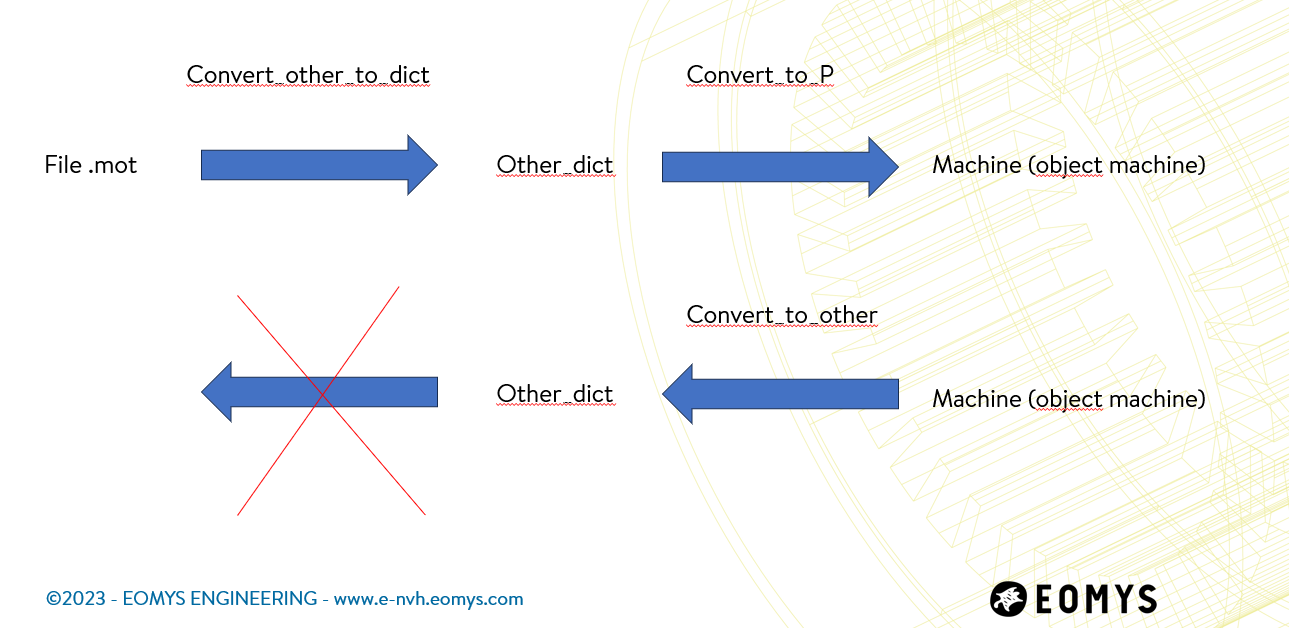

In [18]:
from IPython import display
display.Image("/Users/LAP17/Documents/Converter_WRSM/pyleecan/Tutorials/Images/convert_mot_to_dict.png")

Comme on a un objet machine, on peut le sauvegarder en .json, ou load le .json en machine.
Car le convertisseur peut effectuer les 2 sens de conversion. Et le fonctionnement du convertisseur ne change pas en fonction du sens.

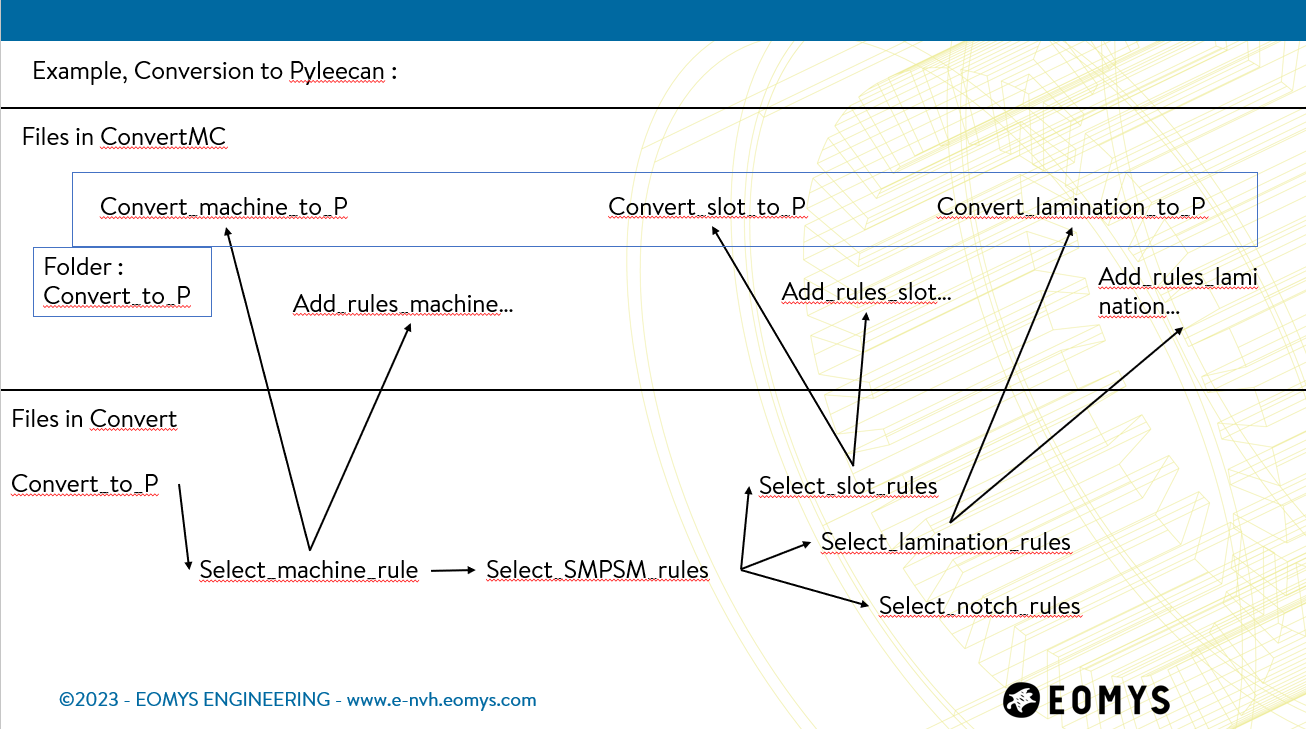

In [25]:
from IPython import display
display.Image("/Users/LAP17/Documents/Converter_WRSM/pyleecan/Tutorials/Images/structure_converter.png")